# `Промышленное машинное обучение на Spark`
## `Задание 03: Spark ML`

<span style="color:red">Дедлайн: 4 декабря 2023. 00:00</span>

<span style="color:red">Заполненный ноутбук присылать на почту <b>ekolmagorov98@yandex.ru</b> с темой письма <b>[HSE Spark 2023][Задание 03][ФИО]</b>.</span>

<span style="color:red">Ваша задача повторить содержимое ноутбука `[Pandas] Task 03.ipynb` с использованием `Spark`. Нумерация ячеек между ноутбуками совпадает. Учитывайте эту нумерацию при выполнении задания. Повторять в точности вывод ячеек в данном ноутбуке не требуется. Вывод приведён только в качестве примера выполнения задания.</span>

<span style="color:red"><b>Использование библиотек `pandas` и `sklearn` запрещено. Переносить Spark DataFrame с датасетом на драйвер запрещено.</b></span>

## `Подключение необходимых библиотек`

In [1]:
! pip install pyspark pyarrow

Defaulting to user installation because normal site-packages is not writeable


In [4]:
! pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 1.0 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [6]:
! pip install seaborn 

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 KB 3.5 MB/s eta 0:00:00a 0:00:01


In [10]:
! pip install pyspark_dist_explore

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 24.7 MB/s eta 0:00:0000:0100:01


In [1]:
import os
from collections import defaultdict

import tqdm as tqdm

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib_inline
import matplotlib.pyplot as plt

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
%matplotlib inline

In [3]:
import pyspark
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.window import Window

import pyspark_dist_explore

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

conf = (
    SparkConf()
        .set('spark.ui.port', '4050')
        .set('spark.driver.memory', '6g')
        .setMaster('local[*]')
)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

24/01/04 19:16:00 WARN Utils: Your hostname, vm-12 resolves to a loopback address: 127.0.1.1; using 10.128.0.28 instead (on interface eth0)
24/01/04 19:16:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/04 19:16:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/04 19:16:13 WARN Utils: Service 'SparkUI' could not bind on port 4050. Attempting port 4051.


## `Загрузка и считывание данных`

Скачаем и распакуем данные из соревнования [Mobile Price Classification](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification).

In [12]:
path = './mobile-price-classification'

import json
import os
import requests
import wget
import urllib.request
import zipfile


folder_url = 'https://disk.yandex.ru/d/Zmrxvz_g8ZyOpQ'
file_url = '/mobile_price.zip'

# запрос ссылки на скачивание
response = requests.get('https://cloud-api.yandex.net/v1/disk/public/resources/download',
                 params={'public_key': folder_url, 'path': file_url}) 

# 'парсинг' ссылки на скачивание
data_link = response.json()['href'] 	

archive_filename = "mobile_price.zip"
urllib.request.urlretrieve(data_link, archive_filename)


with zipfile.ZipFile(archive_filename, 'r') as zip_ref:
    zip_ref.extractall(path)

os.remove(archive_filename)

In [4]:
# 01
# Зададим пути к файлам из датасета

# spark_hse_dpo_2023/Tasks/Task3/mobile-price-classification/test.csv
# spark_hse_dpo_2023/Tasks/Task3/mobile-price-classification/train.csv

path = "./mobile-price-classification"
file_train = f"{path}/train.csv"
file_test = f"{path}/test.csv"

file_type = "csv"
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df_train = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(file_train)
)
df_test = (
    spark.read.format(file_type)
      .option("inferSchema", infer_schema)
      .option("header", first_row_is_header)
      .option("sep", delimiter)
      .load(file_test)
)

In [38]:
# 02
df_train.limit(5).toPandas()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [7]:
# 03
df_test.limit(5).toPandas()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [10]:
# 04
df_train.printSchema()

root
 |-- battery_power: integer (nullable = true)
 |-- blue: integer (nullable = true)
 |-- clock_speed: double (nullable = true)
 |-- dual_sim: integer (nullable = true)
 |-- fc: integer (nullable = true)
 |-- four_g: integer (nullable = true)
 |-- int_memory: integer (nullable = true)
 |-- m_dep: double (nullable = true)
 |-- mobile_wt: integer (nullable = true)
 |-- n_cores: integer (nullable = true)
 |-- pc: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- ram: integer (nullable = true)
 |-- sc_h: integer (nullable = true)
 |-- sc_w: integer (nullable = true)
 |-- talk_time: integer (nullable = true)
 |-- three_g: integer (nullable = true)
 |-- touch_screen: integer (nullable = true)
 |-- wifi: integer (nullable = true)
 |-- price_range: integer (nullable = true)



In [11]:
# 05
df_train.summary().toPandas()

23/12/17 14:55:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,count,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
1,mean,1238.5185,0.495,1.5222499999999983,0.5095,4.3095,0.5215,32.0465,0.5017500000000017,140.249,...,645.108,1251.5155,2124.213,12.3065,5.767,11.011,0.7615,0.503,0.507,1.5
2,stddev,439.4182060835313,0.5001000400170073,0.816004208895068,0.5000347661750049,4.341443747983898,0.49966246736236364,18.145714955206856,0.2884155496235117,35.39965489638834,...,443.78081080643824,432.1994469463379,1084.7320436099492,4.213245004356303,4.356397605826408,5.463955197766688,0.426272922318731,0.5001160445626741,0.5000760322381088,1.1183136021064597
3,min,501,0,0.5,0,0,0,2,0.1,80,...,0,500,256,5,0,2,0,0,0,0
4,25%,851,0,0.7,0,1,0,16,0.2,109,...,282,874,1206,9,2,6,1,0,0,0
5,50%,1225,0,1.5,1,3,1,32,0.5,141,...,564,1247,2146,12,5,11,1,1,1,1
6,75%,1615,1,2.2,1,7,1,48,0.8,170,...,947,1633,3064,16,9,16,1,1,1,2
7,max,1998,1,3.0,1,19,1,64,1.0,200,...,1960,1998,3998,19,18,20,1,1,1,3


## `EDA и визуализация`

Метод [`.spy`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.spy.html) может работать с разреженными матрицами. Можно считать, что пропусков мало, поэтому их можно явно передать на драйвер в координатном виде (каждый пропуск определяется парой номер строки, номер столбца). 

Используйте RDD API, чтобы выделить координатное представление пропусков из DataFrame. Затем создайте разреженную матрицу из этих координат и отрисуйте её.

Полезные методы: `zipWithIndex`, `flatMap`.

In [5]:
from scipy.sparse import csr_matrix

In [ ]:
# 6
# df_train = sc.parallelize([(1, 2, None), (4, None, 6), (7, 8, 9)])
# [(1, 2, None), (4, None, 6), (7, 8, 9)]

# rdd_with_index = df_train.zipWithIndex()
# [((1, 2, None), 0), ((4, None, 6), 1), ((7, 8, 9), 2)]

# rdd_with_index = rdd_with_index.map(lambda x: (x[1], x[0]))
# [(0, (1, 2, None)), (1, (4, None, 6)), (2, (7, 8, 9))]

# sparse_coords_rdd = rdd_with_index.flatMap(lambda x: [(x[0], i) for i, v in enumerate(x[1]) if v is None])
# [(0, 2), (1, 1)]

In [45]:
# 6

# Преобразуем DataFrame в RDD, добавляем индексацию
df_train_rdd = df_train.rdd
rdd_with_index = df_train_rdd.zipWithIndex().map(lambda x: (x[1], x[0]))

# Собираем координаты пропусков
sparse_coords_rdd = rdd_with_index.flatMap(lambda x: [(x[0], i) for i, v in enumerate(x[1]) if v is None])

# Создаем разреженную матрицу из координат пропусков
num_rows = rdd_with_index.count()
num_cols = len(df_train.columns)

print(num_rows, num_cols)
sparse_coords_rdd.collect()

2000 21


[]

Пропусков в данных нет.

In [64]:
# 6

# Преобразуем DataFrame в RDD, добавляем индексацию
df_train_rdd = df_train.rdd
rdd_with_index = df_train_rdd.zipWithIndex().map(lambda x: (x[1], x[0]))

# Собираем координаты пропусков
sparse_coords_rdd = rdd_with_index.flatMap(lambda x: [(x[0], i) for i, v in enumerate(x[1]) if v is None])

# Создаем разреженную матрицу из координат пропусков
row_indices, col_indices = zip(*sparse_coords_rdd.collect())
num_rows = rdd_with_index.count()
num_cols = len(df_train.columns)
sparse_matrix = csr_matrix((np.ones(len(row_indices)), (row_indices, col_indices)), shape=(num_rows, num_cols))

# Отрисовываем разреженную матрицу
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.spy(sparse_matrix, precision=0.0, aspect='auto')

ax.set_xticks(np.arange(num_cols))
ax.set_xticklabels(df_train.columns, rotation=66)
ax.set_ylabel('ID')
ax.grid(False)
ax.set_title('Пропуски в данных')

fig.tight_layout()
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
# 07
# df_train = sc.parallelize([(1, 2, None), (4, None, 6), (7, 8, 9)])
# [(1, 2, None), (4, None, 6), (7, 8, 9)]

# rdd_with_index = df_train.zipWithIndex()
# [((1, 2, None), 0), ((4, None, 6), 1), ((7, 8, 9), 2)]

# sparse_coords_rdd = rdd_with_index.flatMap(lambda x: [(x[1], i) for i, v in enumerate(x[0]) if v == 0])
# [(0, 2), (1, 1)]

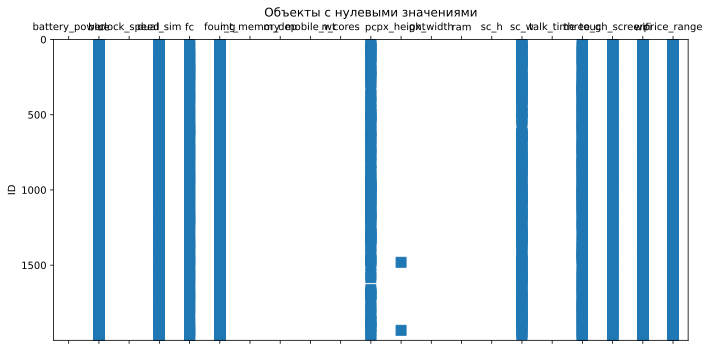

In [6]:
# 07

# Собираем координаты нулей
sparse_coords_rdd = (df_train.rdd
                    .zipWithIndex()
                    .flatMap(lambda x: [(x[1], i) for i, v in enumerate(x[0]) if v == 0]))

# Создаем разреженную матрицу из этих координат
row_indices, col_indices = zip(*sparse_coords_rdd.collect())
num_rows = df_train.count()
num_cols = len(df_train.columns)
sparse_matrix = csr_matrix((np.ones(len(row_indices)), (row_indices, col_indices)), shape=(num_rows, num_cols))

# Отрисовываем разреженную матрицу
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.spy(sparse_matrix, aspect='auto')

ax.set_xticks(np.arange(num_cols), labels=df_train.columns)
ax.set_ylabel('ID')
ax.grid(False)

ax.set_title('Объекты с нулевыми значениями')

fig.tight_layout()
plt.show()

В ячейке ниже можете использовать `pandas`, чтобы создать DataFrame из посчитанных корреляций.

Полезные модули: `pyspark.ml.stat`, `pyspark.ml.feature`.

In [7]:
# 08

# Вычисление корреляции между столбцами
correlations = df_train.select([F.corr(column1, column2).alias(f'corr_{column1}_{column2}') for column1 in df_train.columns for column2 in df_train.columns])

# Вывод рассчитанных корреляций
correlations.toPandas()

24/01/04 19:19:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/01/04 19:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1482.6 KiB
24/01/04 19:19:41 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


,corr_battery_power_battery_power,corr_battery_power_blue,corr_battery_power_clock_speed,corr_battery_power_dual_sim,corr_battery_power_fc,corr_battery_power_four_g,corr_battery_power_int_memory,corr_battery_power_m_dep,corr_battery_power_mobile_wt,corr_battery_power_n_cores,...,corr_price_range_px_height,corr_price_range_px_width,corr_price_range_ram,corr_price_range_sc_h,corr_price_range_sc_w,corr_price_range_talk_time,corr_price_range_three_g,corr_price_range_touch_screen,corr_price_range_wifi,corr_price_range_price_range
0,1.0,0.011252,0.011482,-0.041847,0.033334,0.015665,-0.004004,0.034085,0.001844,-0.029727,...,0.148858,0.165818,0.917046,0.022986,0.038711,0.021859,0.023611,-0.030411,0.018785,1.0


In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [9]:
# 08

vectorAssembler = VectorAssembler(inputCols=df_train.columns, outputCol="features")
df_train_assembled = vectorAssembler.transform(df_train).select("features")

correlations = Correlation.corr(df_train_assembled, "features").head()[0].toArray()

correlations_pd = pd.DataFrame(correlations, columns=df_train.columns, index=df_train.columns)
correlations_pd

24/01/04 19:20:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
battery_power,1.000000,0.011252,0.011482,-0.041847,0.033334,0.015665,-0.004004,0.034085,0.001844,-0.029727,...,0.014901,-0.008402,-0.000653,-0.029959,-0.021421,0.052510,0.011522,-0.010516,-0.008343,0.200723
blue,0.011252,1.000000,0.021419,0.035198,0.003593,0.013443,0.041177,0.004049,-0.008605,0.036161,...,-0.006872,-0.041533,0.026351,-0.002952,0.000613,0.013934,-0.030236,0.010061,-0.021863,0.020573
clock_speed,0.011482,0.021419,1.000000,-0.001315,-0.000434,-0.043073,0.006545,-0.014364,0.012350,-0.005724,...,-0.014523,-0.009476,0.003443,-0.029078,-0.007378,-0.011432,-0.046433,0.019756,-0.024471,-0.006606
dual_sim,-0.041847,0.035198,-0.001315,1.000000,-0.029123,0.003187,-0.015679,-0.022142,-0.008979,-0.024658,...,-0.020875,0.014291,0.041072,-0.011949,-0.016666,-0.039404,-0.014008,-0.017117,0.022740,0.017444
fc,0.033334,0.003593,-0.000434,-0.029123,1.000000,-0.016560,-0.029133,-0.001791,0.023618,-0.013356,...,-0.009990,-0.005176,0.015099,-0.011014,-0.012373,-0.006829,0.001793,-0.014828,0.020085,0.021998
four_g,0.015665,0.013443,-0.043073,0.003187,-0.016560,1.000000,0.008690,-0.001823,-0.016537,-0.029706,...,-0.019236,0.007448,0.007313,0.027166,0.037005,-0.046628,0.584246,0.016758,-0.017620,0.014772
int_memory,-0.004004,0.041177,0.006545,-0.015679,-0.029133,0.008690,1.000000,0.006886,-0.034214,-0.028310,...,0.010441,-0.008335,0.032813,0.037771,0.011731,-0.002790,-0.009366,-0.026999,0.006993,0.044435
m_dep,0.034085,0.004049,-0.014364,-0.022142,-0.001791,-0.001823,0.006886,1.000000,0.021756,-0.003504,...,0.025263,0.023566,-0.009434,-0.025348,-0.018388,0.017003,-0.012065,-0.002638,-0.028353,0.000853
mobile_wt,0.001844,-0.008605,0.012350,-0.008979,0.023618,-0.016537,-0.034214,0.021756,1.000000,-0.018989,...,0.000939,0.000090,-0.002581,-0.033855,-0.020761,0.006209,0.001551,-0.014368,-0.000409,-0.030302
n_cores,-0.029727,0.036161,-0.005724,-0.024658,-0.013356,-0.029706,-0.028310,-0.003504,-0.018989,1.000000,...,-0.006872,0.024480,0.004868,-0.000315,0.025826,0.013148,-0.014733,0.023774,-0.009964,0.004399


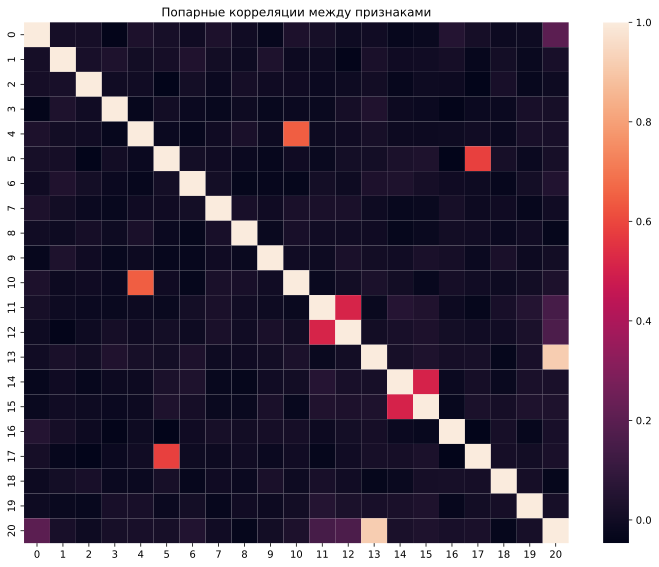

In [10]:
# 09
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(correlations, ax=ax)
ax.set_title('Попарные корреляции между признаками')

fig.tight_layout()
plt.show()

In [119]:
# 10

count_ = df_train.groupBy('price_range').count().show(10, truncate=False)

+-----------+-----+
|price_range|count|
+-----------+-----+
|1          |500  |
|3          |500  |
|2          |500  |
|0          |500  |
+-----------+-----+



In [113]:
# 10

count = df_train.groupBy("price_range").agg(F.count("price_range").alias("count")).show(10, truncate=False)

+-----------+-----+
|price_range|count|
+-----------+-----+
|1          |500  |
|3          |500  |
|2          |500  |
|0          |500  |
+-----------+-----+



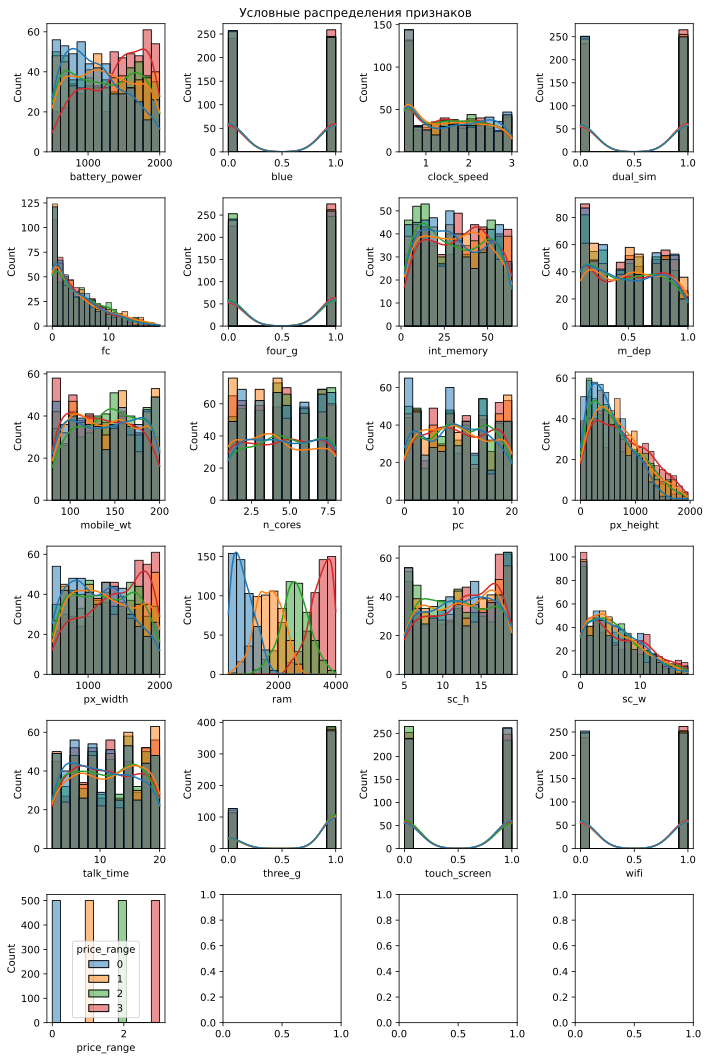

In [11]:
# 11

df_train_pd = df_train.toPandas()

grid_size = np.array([6, (len(df_train.columns) - 1) // 6 + 1])
fig, axes = plt.subplots(*grid_size, figsize=2.5 * grid_size[::-1])

for ax, column in zip(axes.reshape(-1), df_train.columns):
    sns.histplot(
        df_train_pd, x=column, hue='price_range', kde=True, palette='tab10', ax=ax, legend=column == 'price_range'
    )
    
fig.suptitle('Условные распределения признаков')

fig.tight_layout()
plt.show()

`boxplot` определяется следующим набором статистик:
 1. Квантили Q1, median, Q3
 2. Нижняя и верхняя граница выборосов (Q1 - 1.5IQR / Q3 + 1.5IQR, но не меньше/больше минимума/максимума выборки)
 3. Выбросы
 
 Чтобы нарисовать `boxplot` по этим статистикам можно использовать метод [`.bxp`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bxp.html).
 
 Реализуйте вспомогательную функцию `draw_boxplot`. Эта функция принимает на вход Spark DataFrame, название колонки для группировки данных `x`, название колонки с данными `y` и оси для отрисовки `ax`. Функция выполняет группировку данных, в каждой группе считает указанные статитстики и затем отрисовывает на их основе набор boxplot.

Диаграмма "Ящик с усами":
```txt
    Q1-1.5IQR   Q1   median  Q3   Q3+1.5IQR
                  |-----:-----|
  o      |--------|     :     |--------|    o  o
                  |-----:-----|
flier             <----------->            fliers
                       IQR
```

In [672]:
# Генерируем случайную выборку с выбросами для тестирования функции
np.random.seed(0)
data__ = {
    'x': np.random.choice(['A', 'B', 'C', 'D'], size=100),
    'y': np.concatenate([np.random.normal(0, 1, 90), np.random.normal(10, 1, 10)])
}
df__ = spark.createDataFrame(pd.DataFrame(data__))

In [592]:
# Тест на данных

# Вычисляем квартили
quantiles_df = df__.groupBy('x').agg(
    F.expr(f"percentile_approx(y, 0.25)").alias("Q1"),
    F.expr(f"percentile_approx(y, 0.5)").alias("median"),
    F.expr(f"percentile_approx(y, 0.75)").alias("Q3")
)

# Вычисляем нижние и верхние границы выбросов
IQR = quantiles_df["Q3"] - quantiles_df["Q1"]
min_max_y = df__.select(F.min('y').alias("min_y"), F.max('y').alias("max_y")).first()
min_y = min_max_y["min_y"]
max_y = min_max_y["max_y"]
print(min_y)
lower_bound = F.when(quantiles_df["Q1"] - 1.5 * IQR < min_y, min_y).otherwise(quantiles_df["Q1"] - 1.5 * IQR).alias("lower_bound") #но не меньше минимума выборки
upper_bound = F.when(quantiles_df["Q3"] + 1.5 * IQR > max_y, max_y).otherwise(quantiles_df["Q3"] + 1.5 * IQR).alias("upper_bound") #но не больше максимума выборки
stats_df = quantiles_df.withColumn("lower_bound", lower_bound).withColumn("upper_bound", upper_bound)
stats_df = quantiles_df.withColumn("lower_bound", lower_bound).withColumn("upper_bound", upper_bound)
stats_df = stats_df.orderBy('x')

# Присоединяем к исходному df статистики по выбросам
data_stats_df = df__.join(stats_df, on=['x'], how='left')

# Находим выбросы
outliers = data_stats_df.filter((F.col('y') < F.col("lower_bound")) | (F.col('y') > F.col("upper_bound")))
stats = stats_df.join(outliers.groupBy('x').agg(F.collect_list('y').alias("outliers_list")), on=['x'], how='left').collect()

# Преобразуем в словарь

stats = [
    {
        'label': str(row['x']),
        'med': row['median'],
        'q1': row['Q1'],
        'q3': row['Q3'],
        'whislo': row['lower_bound'],
        'whishi': row['upper_bound'],
        'fliers': row['outliers_list']
    }
    for row in stats
]

stats

-1.7262826023316769


[{'label': 'A',
  'med': 0.3024718977397814,
  'q1': -0.6343220936809636,
  'q3': 1.4805147914344243,
  'whislo': -1.7262826023316769,
  'whishi': 4.652770119107506,
  'fliers': [9.791701244422006, 10.439391701264537]},
 {'label': 'B',
  'med': 0.05194539579613895,
  'q1': -0.5096521817516535,
  'q3': 0.7065731681919482,
  'whislo': -1.7262826023316769,
  'whishi': 2.5309111931073507,
  'fliers': [8.508742407294395]},
 {'label': 'C',
  'med': 0.298238174206056,
  'q1': -0.40317694697317963,
  'q3': 1.9229420264803847,
  'whislo': -1.7262826023316769,
  'whishi': 5.412120486660731,
  'fliers': [9.364153921621119, 10.6764332949465, 10.396006712661645]},
 {'label': 'D',
  'med': 0.12691209270361992,
  'q1': -1.1651498407833565,
  'q3': 1.1787795711596507,
  'whislo': -1.7262826023316769,
  'whishi': 4.694673689074161,
  'fliers': [9.325667339342624,
   10.03183055827435,
   10.57659081661494,
   8.906938491269495]}]

In [12]:
def draw_boxplot(df, x, y, ax):

    # Вычисляем квартили
    quantiles_df = df.groupBy(x).agg(
        F.expr(f"percentile_approx({y}, 0.25)").alias("Q1"),
        F.expr(f"percentile_approx({y}, 0.5)").alias("median"),
        F.expr(f"percentile_approx({y}, 0.75)").alias("Q3")
    )

    # Вычисляем нижние и верхние границы выбросов
    IQR = quantiles_df["Q3"] - quantiles_df["Q1"]
    min_max_y = df.select(F.min(y).alias("min_y"), F.max(y).alias("max_y")).first()
    min_y = min_max_y["min_y"]
    max_y = min_max_y["max_y"]

    lower_bound = F.when(quantiles_df["Q1"] - 1.5 * IQR < min_y, min_y).otherwise(quantiles_df["Q1"] - 1.5 * IQR).alias("lower_bound") #но не меньше минимума выборки
    upper_bound = F.when(quantiles_df["Q3"] + 1.5 * IQR > max_y, max_y).otherwise(quantiles_df["Q3"] + 1.5 * IQR).alias("upper_bound") #но не больше максимума выборки
    stats_df = quantiles_df.withColumn("lower_bound", lower_bound).withColumn("upper_bound", upper_bound)
    stats_df = quantiles_df.withColumn("lower_bound", lower_bound).withColumn("upper_bound", upper_bound)
    stats_df = stats_df.orderBy(x)

    # Присоединяем к исходному df статистики
    data_stats_df = df.join(stats_df, on=[x], how='left')

    # Находим выбросы
    outliers = data_stats_df.filter((F.col(y) < F.col("lower_bound")) | (F.col(y) > F.col("upper_bound")))

    # Присоединяем к stats выбросы
    stats = stats_df.join(outliers.groupBy(x).agg(F.collect_list(y).alias("outliers_list")), on=[x], how='left').collect()   

    # Преобразуем в словарь
    stats = [
        {
            'label': str(row[x]),
            'med': row['median'],
            'q1': row['Q1'],
            'q3': row['Q3'],
            'whislo': row['lower_bound'],
            'whishi': row['upper_bound'],
            'fliers': row['outliers_list'] if row['outliers_list'] is not None else [] # есть сложности, если выбросов нет
        }
        for row in stats
    ]

    # boxplot
    boxes = ax.bxp(stats, showfliers=True)['boxes']
    for box in boxes:
        ax.fill(box.get_xdata(), box.get_ydata(), facecolor='blue', edgecolor='black')

    # Зададим длину оси y
    ax.set_ylim(min_y - 1, max_y + 1)
    
    # Зададим подписи оси x
    ax.set_xticks(range(1, len(stats) + 1))
    ax.set_xticklabels([stat['label'] for stat in stats])

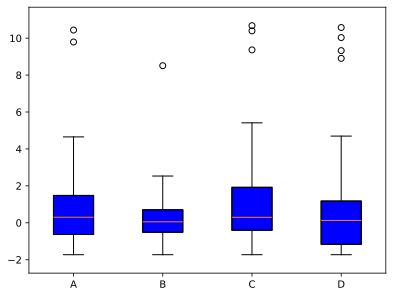

In [693]:
# Создаем график
fig, ax = plt.subplots()
draw_boxplot(df__, 'x', 'y', ax)
plt.show()

In [695]:
# Вариант 2 
def draw_boxplot(df, x, y, ax):

    # Вычисляем квартили
    quantiles_df = df.groupBy(x).agg(
        F.expr(f"percentile_approx({y}, 0.25)").alias("Q1"),
        F.expr(f"percentile_approx({y}, 0.5)").alias("median"),
        F.expr(f"percentile_approx({y}, 0.75)").alias("Q3")
    )

    # Вычисляем нижние и верхние границы выбросов
    IQR = quantiles_df["Q3"] - quantiles_df["Q1"]
    min_max_y = df.select(F.min(y).alias("min_y"), F.max(y).alias("max_y")).first()
    min_y = min_max_y["min_y"]
    max_y = min_max_y["max_y"]

    lower_bound = F.when(quantiles_df["Q1"] - 1.5 * IQR < min_y, min_y).otherwise(quantiles_df["Q1"] - 1.5 * IQR).alias("lower_bound") #но не меньше минимума выборки
    upper_bound = F.when(quantiles_df["Q3"] + 1.5 * IQR > max_y, max_y).otherwise(quantiles_df["Q3"] + 1.5 * IQR).alias("upper_bound") #но не больше максимума выборки
    stats_df = quantiles_df.withColumn("lower_bound", lower_bound).withColumn("upper_bound", upper_bound)
    stats_df = quantiles_df.withColumn("lower_bound", lower_bound).withColumn("upper_bound", upper_bound)
    stats_df = stats_df.orderBy(x)

    # Присоединяем к исходному df статистики
    data_stats_df = df.join(stats_df, on=[x], how='left')

    # Находим выбросы
    outliers = data_stats_df.filter((F.col(y) < F.col("lower_bound")) | (F.col(y) > F.col("upper_bound")))

    # Преобразуем в словарь    
    stats = stats_df.collect()
    stats = [
        {
            'label': str(row[x]),
            'med': row['median'],
            'q1': row['Q1'],
            'q3': row['Q3'],
            'whislo': row['lower_bound'],
            'whishi': row['upper_bound'],
            'fliers': outliers.filter(F.col(x) == row[x]).select(y).rdd.flatMap(lambda x: x).collect()
        }
        for row in stats
    ]

    # boxplot
    boxes = ax.bxp(stats, showfliers=True)['boxes']
    for box in boxes:
        ax.fill(box.get_xdata(), box.get_ydata(), facecolor='blue', edgecolor='black')

    # Зададим длину оси y
    ax.set_ylim(min_y - 1, max_y + 1)
    
    # Зададим подписи оси x
    ax.set_xticks(range(1, len(stats) + 1))
    ax.set_xticklabels([stat['label'] for stat in stats])

In [ ]:
# Создаем график
fig, ax = plt.subplots()
draw_boxplot(df__, 'x', 'y', ax)
plt.show()

In [697]:
# Вариант 3 и 4 

def draw_boxplot(df, x, y, ax):

    # Вычисляем квартили
    quantiles_df = df.groupBy(x).agg(
        F.expr(f"percentile_approx({y}, 0.25)").alias("Q1"),
        F.expr(f"percentile_approx({y}, 0.5)").alias("median"),
        F.expr(f"percentile_approx({y}, 0.75)").alias("Q3")
    )

    # Вычисляем нижние и верхние границы выбросов
    IQR = quantiles_df["Q3"] - quantiles_df["Q1"]
    min_max_y = df.select(F.min(y).alias("min_y"), F.max(y).alias("max_y")).first()
    min_y = min_max_y["min_y"]
    max_y = min_max_y["max_y"]

    lower_bound = F.when(quantiles_df["Q1"] - 1.5 * IQR < min_y, min_y).otherwise(quantiles_df["Q1"] - 1.5 * IQR).alias("lower_bound") #но не меньше минимума выборки
    upper_bound = F.when(quantiles_df["Q3"] + 1.5 * IQR > max_y, max_y).otherwise(quantiles_df["Q3"] + 1.5 * IQR).alias("upper_bound") #но не больше максимума выборки
    stats_df = quantiles_df.withColumn("lower_bound", lower_bound).withColumn("upper_bound", upper_bound)
    stats_df = quantiles_df.withColumn("lower_bound", lower_bound).withColumn("upper_bound", upper_bound)
    stats_df = stats_df.orderBy(x)

    # Присоединяем к исходному df статистики
    data_stats_df = df.join(stats_df, on=[x], how='left')

    # Находим выбросы 
    outliers = data_stats_df.filter((F.col(y) < F.col('lower_bound')) | (F.col(y) > F.col('upper_bound'))).toPandas()

    # Преобразуем в словарь   
    stats = stats_df.collect()
    stats = [
        {
            'label': str(row[x]),
            'med': row['median'],
            'q1': row['Q1'],
            'q3': row['Q3'],
            'whislo': row['lower_bound'],
            'whishi': row['upper_bound'],
            'fliers': []
        }
        for row in stats
    ]

    boxes = ax.bxp(stats, showfliers=False)['boxes']
    for box in boxes:
        ax.fill(box.get_xdata(), box.get_ydata(), facecolor='blue', edgecolor='black')

    # Зададим длину оси y
    ax.set_ylim(min_y - 1, max_y + 1)

    
    # Вариант 3 Отрисуем выбросы
    for i, label in enumerate([stat['label'] for stat in stats]):
        fliers = outliers[outliers[x] == label][y]
        ax.plot([i + 1] * len(fliers), fliers, 'r+', markersize=5)

    # Вариант 4 Отрисуем выбросы
    for i, stat in enumerate(stats):
        outliers_for_x = outliers[outliers[x] == stat['label']][y]
        ax.plot([i+1] * len(outliers_for_x), outliers_for_x, 'r.', markersize=5)
    

    ax.set_xticks(range(1, len(stats) + 1))
    ax.set_xticklabels([stat['label'] for stat in stats])

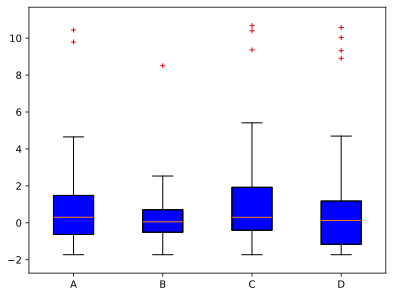

In [665]:
# Создаем график
fig, ax = plt.subplots()
draw_boxplot(df__, 'x', 'y', ax)
plt.show()

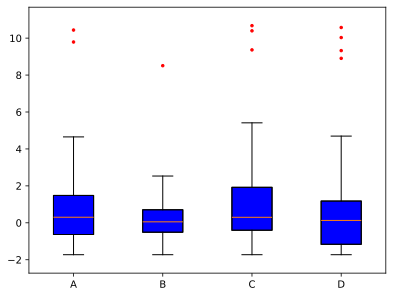

In [667]:
# Создаем график
fig, ax = plt.subplots()
draw_boxplot(df__, 'x', 'y', ax)
plt.show()

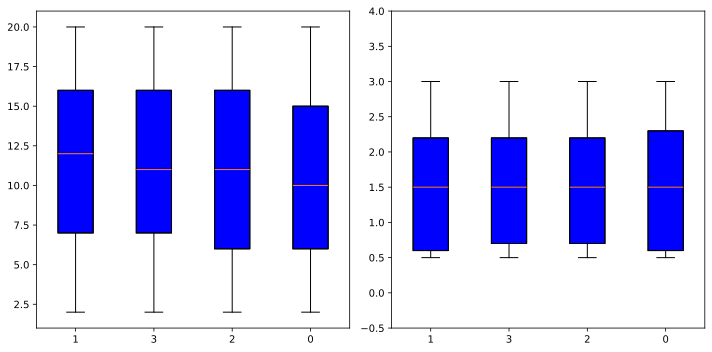

In [14]:
# 12

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

draw_boxplot(df_train, 'price_range', 'talk_time', ax=axes[0])
draw_boxplot(df_train, 'price_range', 'clock_speed', ax=axes[1])

fig.tight_layout()
plt.show()

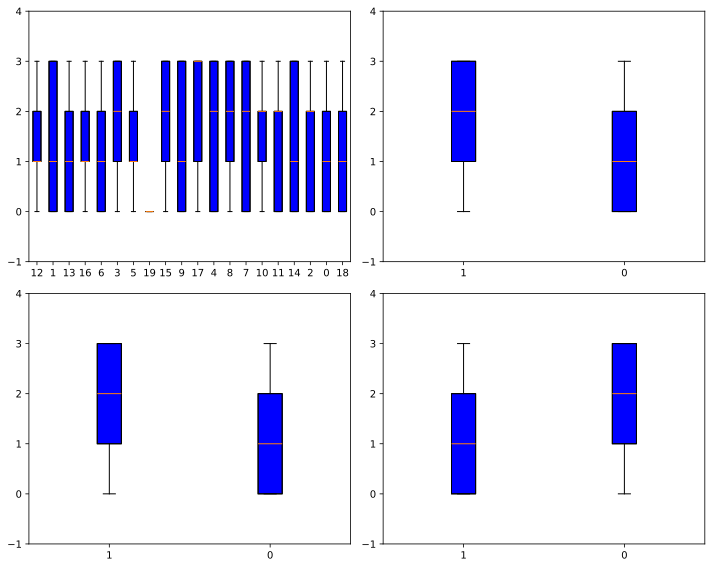

In [15]:
# 13

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

draw_boxplot(df_train, 'fc', 'price_range', ax=axes[0, 0])
draw_boxplot(df_train, 'wifi','price_range', ax=axes[0, 1])
draw_boxplot(df_train, 'dual_sim', 'price_range', ax=axes[1, 0])
draw_boxplot(df_train, 'touch_screen', 'price_range', ax=axes[1, 1])

fig.tight_layout()
plt.show()

In [16]:
# 14
three_g_values = df_train.groupBy("three_g").count().orderBy("count", ascending=False)
four_g_values = df_train.groupBy("four_g").count().orderBy("count", ascending=False)

three_g_values.show()
four_g_values.show()

+-------+-----+
|three_g|count|
+-------+-----+
|      1| 1523|
|      0|  477|
+-------+-----+

+------+-----+
|four_g|count|
+------+-----+
|     1| 1043|
|     0|  957|
+------+-----+



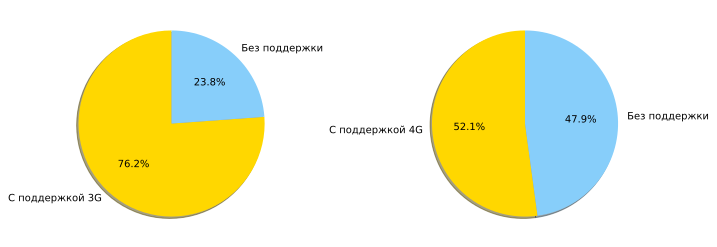

In [17]:
# 15

three_g_values_count = three_g_values.select("count").rdd.flatMap(lambda x: x).collect()
four_g_values_count = four_g_values.select("count").rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].pie(
    three_g_values_count, labels=["С поддержкой 3G", 'Без поддержки'], autopct='%1.1f%%',
    shadow=True, startangle=90, colors=['gold', 'lightskyblue']
)
axes[1].pie(
    four_g_values_count, labels=["С поддержкой 4G", 'Без поддержки'], autopct='%1.1f%%',
    shadow=True, startangle=90, colors=['gold', 'lightskyblue']
)

fig.tight_layout()
plt.show()

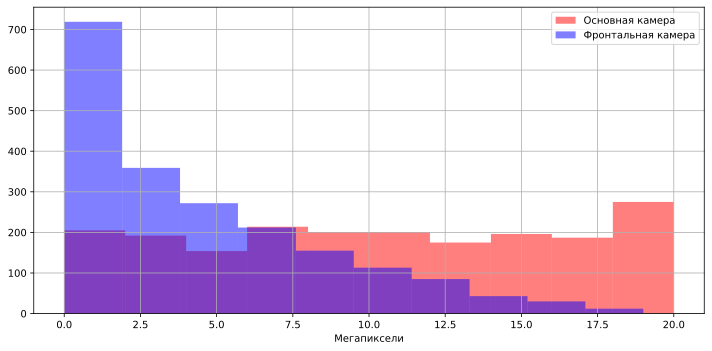

In [18]:
# 16

df_pc = df_train.select('pc').toPandas()
df_fc = df_train.select('fc').toPandas()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.hist(df_pc, alpha=0.5,color='red', label='Основная камера')
ax.hist(df_fc, alpha=0.5, color='blue', label='Фронтальная камера')
ax.legend()
ax.grid(True)

ax.set_xlabel('Мегапиксели')

fig.tight_layout()
plt.show()

## `Обучение моделей и оценка качества`

In [20]:
from pyspark.ml import Pipeline

from pyspark.ml.feature import VectorAssembler, StandardScaler

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [21]:
# 17

label_column = 'price_range'
feature_columns = [column for column in df_train.columns if column != label_column]

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
vectorized_data = assembler.transform(df_train)

scaler = StandardScaler(inputCol='features', outputCol='features_scaled', withMean=True, withStd=True)
scalerModel = scaler.fit(vectorized_data)
scaled_data = scalerModel.transform(vectorized_data)

data_train, data_test = scaled_data.randomSplit([0.7, 0.3], seed=6417)

In [41]:
# 18
logistic_regressor = LogisticRegression(featuresCol='features_scaled', labelCol=label_column, predictionCol='prediction')
logistic_regressor_trained = logistic_regressor.fit(data_train)

In [42]:
# 19
predictions_train = logistic_regressor_trained.transform(data_train)
predictions_test = logistic_regressor_trained.transform(data_test)

Можете использовать [MulticlassMetrics](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.MulticlassMetrics.html) для подсчёта метрик через RDD API.

In [203]:
# 20
evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)

print('Accuracy (Train/Test): {0:.1f}%/{1:.1f}%'.format(100.0 * accuracy_train, 100.0 * accuracy_test))

# Фактические классы и предсказания
predictions_test.groupBy(label_column, 'prediction').count().orderBy(label_column, 'prediction').show()

# Создание объекта MulticlassMetrics для вычисления матрицы ошибок и отчета о классификации
predictionAndLabels_test = predictions_test.select("prediction", label_column).rdd.map(lambda row: (float(row.prediction), float(row[label_column])))

metrics_test = MulticlassMetrics(predictionAndLabels_test)

# Confusion Matrix
# В исходном варианте (scikit-learn) Confusion Matrix (Матрица ошибок): в строках матрицы представлены фактические классы, а в столбцах - предсказанные классы. 
# Она показывает, сколько элементов каждого класса было верно или ошибочно классифицировано
print('\nConfusion Matrix (Test)', metrics_test.confusionMatrix().toArray(), sep='\n')

label_ = df_train.select(label_column).distinct().orderBy(F.col("price_range")).rdd.map(lambda row: (float(row[0]))).collect()

# Classification Report
# В исходном варианте (scikit-learn) Classification Report (Отчет о классификации): содержит различные метрики оценки производительности модели, такие как точность (precision), полнота (recall) и F1-мера для каждого класса. 
# Он также включает общие показатели для всей модели, такие как средневзвешенная точность, полнота и F1-мера.
metrics_df_test = spark.createDataFrame([
    (int(k), 
     metrics_test.precision(k), metrics_test.recall(k), metrics_test.fMeasure(k), 
     data_test.groupBy(label_column).count().filter(F.col(label_column) == k).rdd.map(lambda row: (float(row[1]))).first())
    for k in label_
], ["label", "precision", "recall", "f1-score", "support"])

print('\nClassification Report (Test)')
metrics_df_test.show()


Accuracy (Train/Test): 100.0%/96.8%
+-----------+----------+-----+
|price_range|prediction|count|
+-----------+----------+-----+
|          0|       0.0|  163|
|          0|       1.0|    4|
|          1|       0.0|    2|
|          1|       1.0|  126|
|          1|       2.0|    3|
|          2|       1.0|    4|
|          2|       2.0|  146|
|          2|       3.0|    6|
|          3|       3.0|  140|
+-----------+----------+-----+


Confusion Matrix (Test)
[[163.   4.   0.   0.]
 [  2. 126.   3.   0.]
 [  0.   4. 146.   6.]
 [  0.   0.   0. 140.]]

Classification Report (Test)
+-----+------------------+------------------+------------------+-------+
|label|         precision|            recall|          f1-score|support|
+-----+------------------+------------------+------------------+-------+
|    0|0.9878787878787879|0.9760479041916168|0.9819277108433735|  167.0|
|    1|0.9402985074626866|0.9618320610687023|0.9509433962264152|  131.0|
|    2|0.9798657718120806|0.9358974358974359| 0

Случайный лес

In [22]:
# 21
# Вариант 1
# Ближе к коду на pandas: rf_model внутри цикла

# Подготовка параметров для обучения
sr_range = [0.1, 0.3, 0.7, 0.9]
max_depth_range = [1, 2, 3, 5, 8]

# Подготовка списка для хранения результатов кросс-валидации
scores = defaultdict(lambda: defaultdict(float))

# Создание объекта оценки
evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")

# Перебор всех комбинаций параметров и оценка качества
for sr in sr_range:
    for max_depth in max_depth_range:
        # Создание модели RandomForestClassifier
        rf_model = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=200, seed=42, maxDepth=max_depth, subsamplingRate=sr)

        # Создание объекта кросс-валидации
        param_grid = ParamGridBuilder().build()
        crossval = CrossValidator(estimator=rf_model, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

        # Обучение модели и оценка качества через кросс-валидацию
        cv_model = crossval.fit(data_train)

        # Получение оценки качества и сохранение в словаре scores
        accuracy = cv_model.avgMetrics[0]
        scores[sr][max_depth] = accuracy

# Вывод результатов
print(scores)

24/01/04 19:34:52 WARN DAGScheduler: Broadcasting large task binary with size 1100.8 KiB
24/01/04 19:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1106.5 KiB
24/01/04 19:34:56 WARN DAGScheduler: Broadcasting large task binary with size 1124.9 KiB
24/01/04 19:35:00 WARN DAGScheduler: Broadcasting large task binary with size 1139.7 KiB
24/01/04 19:35:00 WARN DAGScheduler: Broadcasting large task binary with size 1368.5 KiB
24/01/04 19:35:00 WARN DAGScheduler: Broadcasting large task binary with size 1375.4 KiB
24/01/04 19:35:01 WARN DAGScheduler: Broadcasting large task binary with size 1466.7 KiB
24/01/04 19:35:03 WARN DAGScheduler: Broadcasting large task binary with size 1151.2 KiB
24/01/04 19:35:03 WARN DAGScheduler: Broadcasting large task binary with size 1348.8 KiB
24/01/04 19:35:03 WARN DAGScheduler: Broadcasting large task binary with size 1356.8 KiB
24/01/04 19:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1474.0 KiB
24/01/04 19:35:05 WAR

defaultdict(<function <lambda> at 0x7f8444659bd0>, {0.1: defaultdict(<class 'float'>, {1: 0.7016024444871256, 2: 0.7603528628408704, 3: 0.7894486989003348, 5: 0.8224752774407524, 8: 0.8175000331820234}), 0.3: defaultdict(<class 'float'>, {1: 0.6103103605727815, 2: 0.7441418634295586, 3: 0.7781784507092104, 5: 0.8187931008457642, 8: 0.8426411446158458}), 0.7: defaultdict(<class 'float'>, {1: 0.6042815187581231, 2: 0.7430479529684509, 3: 0.7901024010251815, 5: 0.8239191020970518, 8: 0.8548622041659965}), 0.9: defaultdict(<class 'float'>, {1: 0.5787904931291091, 2: 0.7482534511906751, 3: 0.7857849773659563, 5: 0.8169929695750775, 8: 0.8533042463620791})})


In [ ]:
# 21
# Вариант 2
# В данном коде используется одна и та же модель RandomForestClassifier, что позволяет избежать излишней нагрузки на систему
# метод setParams для изменения параметров модели, метод addGrid для создания сетки параметров и метод CrossValidator для обучения модели и оценки ее качества через кросс-валидацию

# Создание параметров для обучения
sr_range = [0.1, 0.3, 0.7, 0.9]
max_depth_range = [1, 2, 3, 5, 8]

# Определение модели RandomForestClassifier
rf_model = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=200, seed=42)

# Создание объекта оценки
evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")

# Подготовка списка для хранения результатов кросс-валидации
scores = defaultdict(lambda: defaultdict(float))

# Перебор всех комбинаций параметров и оценка качества
for sr in sr_range:
    for max_depth in max_depth_range:
        
        # Изменение параметров модели
        rf_model.setParams(maxDepth=max_depth, subsamplingRate=sr)
        
        # Создание сетки параметров для перебора
        param_grid = ParamGridBuilder().addGrid(rf_model.maxDepth, [max_depth]).addGrid(rf_model.subsamplingRate, [sr]).build()
        
        # Создание объекта кросс-валидации
        crossval = CrossValidator(estimator=rf_model,
                                  estimatorParamMaps=param_grid,
                                  evaluator=evaluator,
                                  numFolds=3)

        # Обучение модели и оценка качества через кросс-валидацию
        cv_model = crossval.fit(data_train)

        # Получение оценки качества и сохранение в словаре scores
        accuracy = cv_model.avgMetrics[0]
        scores[sr][max_depth] = accuracy

# Вывод результатов
print(scores)

In [ ]:
# 21
# Вариант 3

# Создание параметров для обучения
sr_range = [0.1, 0.3, 0.7, 0.9]
max_depth_range = [1, 2, 3, 5, 8]

# Определение модели RandomForestClassifier
rf_model = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=200, seed=42)

# Создание объекта оценки
evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")

# Подготовка списка для хранения результатов кросс-валидации
scores = defaultdict(lambda: defaultdict(float))

# Перебор всех комбинаций параметров и оценка качества
for sr in sr_range:
    for max_depth in max_depth_range:
        
        # Создание новой модели для каждой комбинации параметров
        rf_model_new = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=200, seed=42, maxDepth=max_depth, subsamplingRate=sr)
        
        # Создание объекта кросс-валидации
        crossval = CrossValidator(estimator=rf_model_new,
                                  evaluator=evaluator,
                                  estimatorParamMaps=ParamGridBuilder().build(),
                                  numFolds=3)

        # Обучение модели и оценка качества через кросс-валидацию
        cv_model = crossval.fit(data_train)

        # Получение оценки качества и сохранение в словаре scores
        accuracy = cv_model.avgMetrics[0]
        scores[sr][max_depth] = accuracy

# Вывод результатов
print(scores)

In [ ]:
# 21
# Вариант 4
# Создаем новую модель для каждой комбинации параметров, поэтому мы настраиваем модель с учетом текущих значений subsamplingRate и maxDepth
# Создаем сетку параметров для кросс-валидации, используя ParamGridBuilder

# Создание параметров для обучения
sr_range = [0.1, 0.3, 0.7, 0.9]
max_depth_range = [1, 2, 3, 5, 8]

# Определение модели RandomForestClassifier
rf_model = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=200, seed=42)

# Создание объекта оценки
evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")

# Подготовка списка для хранения результатов кросс-валидации
scores = defaultdict(lambda: defaultdict(float))

# Перебор всех комбинаций параметров и оценка качества
for sr in sr_range:
    for max_depth in max_depth_range:
        
        # Создание новой модели для каждой комбинации параметров
        rf_model_new = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=200, seed=42, maxDepth=max_depth, subsamplingRate=sr)
        
        # Создание объекта кросс-валидации с параметром сетки
        param_grid = ParamGridBuilder() \
            .addGrid(rf_model_new.maxDepth, [max_depth]) \
            .addGrid(rf_model_new.subsamplingRate, [sr]) \
            .build()
        
        crossval = CrossValidator(estimator=rf_model_new,
                                  estimatorParamMaps=param_grid,
                                  evaluator=evaluator,
                                  numFolds=3)

        # Обучение модели и оценка качества через кросс-валидацию
        cv_model = crossval.fit(data_train)

        # Получение оценки качества и сохранение в словаре scores
        accuracy = cv_model.avgMetrics[0]
        scores[sr][max_depth] = accuracy

# Вывод результатов
print(scores)

In [23]:
print(scores)

defaultdict(<function <lambda> at 0x7f8444659bd0>, {0.1: defaultdict(<class 'float'>, {1: 0.7016024444871256, 2: 0.7603528628408704, 3: 0.7894486989003348, 5: 0.8224752774407524, 8: 0.8175000331820234}), 0.3: defaultdict(<class 'float'>, {1: 0.6103103605727815, 2: 0.7441418634295586, 3: 0.7781784507092104, 5: 0.8187931008457642, 8: 0.8426411446158458}), 0.7: defaultdict(<class 'float'>, {1: 0.6042815187581231, 2: 0.7430479529684509, 3: 0.7901024010251815, 5: 0.8239191020970518, 8: 0.8548622041659965}), 0.9: defaultdict(<class 'float'>, {1: 0.5787904931291091, 2: 0.7482534511906751, 3: 0.7857849773659563, 5: 0.8169929695750775, 8: 0.8533042463620791})})


In [ ]:
# Не корректное сохранение в словарь scores - не понятно в чем ошибка

# Создание параметров для обучения
sr_range = [0.1, 0.3, 0.7, 0.9]
max_depth_range = [1, 2, 3, 5, 8]

# Создание сетки параметров
param_grid = ParamGridBuilder() \
    .addGrid(RandomForestClassifier.subsamplingRate, sr_range) \
    .addGrid(RandomForestClassifier.maxDepth, max_depth_range) \
    .build()

# Создание модели RandomForestClassifier
rf_model = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=200, seed=42)

# Оценка качества модели через кросс-валидацию
evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=rf_model,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

# Обучение модели и оценка качества
cv_model = crossval.fit(data_train)

# Сохранение результатов кросс-валидации в словаре scores
scores = defaultdict(lambda: defaultdict(float))

for params, score in zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics):
    sr = params[RandomForestClassifier.subsamplingRate]
    max_depth = params[RandomForestClassifier.maxDepth]
    scores[sr][max_depth] = score

print(scores)


# Результат выполнения кода:
# defaultdict(<function <lambda> at 0x7fa2480c1750>, {0.1: defaultdict(<class 'float'>, {1: 0.8191336024485082, 2: 0.8191336024485082, 3: 0.8191336024485082, 5: 0.8191336024485082, 8: 0.8191336024485082}), 0.3: defaultdict(<class 'float'>, {1: 0.8191336024485082, 2: 0.8191336024485082, 3: 0.8191336024485082, 5: 0.8191336024485082, 8: 0.8191336024485082}), 0.7: defaultdict(<class 'float'>, {1: 0.8191336024485082, 2: 0.8191336024485082, 3: 0.8191336024485082, 5: 0.8191336024485082, 8: 0.8191336024485082}), 0.9: defaultdict(<class 'float'>, {1: 0.8191336024485082, 2: 0.8191336024485082, 3: 0.8191336024485082, 5: 0.8191336024485082, 8: 0.8191336024485082})})

In [65]:
# Получение лучших параметров
best_model = cv_model.bestModel
best_params = best_model.extractParamMap()
best_sr = best_params[best_model.getParam("subsamplingRate")]
best_max_depth = best_params[best_model.getParam("maxDepth")]
best_sr, best_max_depth

(0.9, 8)

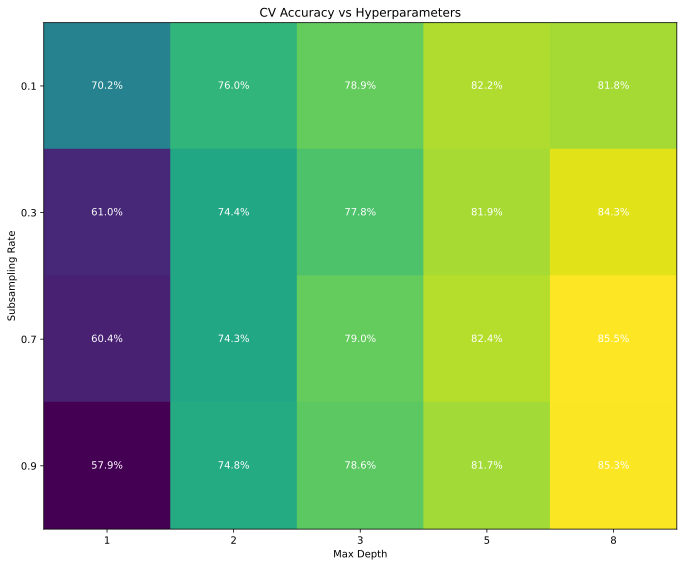

In [24]:
# 22
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

scores_array = [[np.mean(__) for __ in _.values()] for _ in scores.values()]

ax.imshow(scores_array)
for idx in range(len(sr_range)):
    for jdx in range(len(max_depth_range)):
        text = ax.text(
            jdx, idx, '{0:.1f}%'.format(100.0 * scores_array[idx][jdx]),
            ha="center", va="center", color="w"
        )

ax.set_xlabel('Max Depth')
ax.set_ylabel('Subsampling Rate')
ax.set_title('CV Accuracy vs Hyperparameters')

ax.set_xticks(np.arange(len(max_depth_range)), max_depth_range)
ax.set_yticks(np.arange(len(sr_range)), sr_range)

fig.tight_layout()
plt.show()

In [69]:
scores_array

[[0.6794481334024586,
  0.764964215482172,
  0.7883932566857134,
  0.8092866622229055,
  0.8158925819269203],
 [0.6041544655132389,
  0.7392829269324915,
  0.7751648205971443,
  0.8023124258724823,
  0.8302102011082019],
 [0.5678670423325306,
  0.7270399965478904,
  0.7785269450220434,
  0.8159072336839589,
  0.8457400522090078],
 [0.5574496430780121,
  0.7087723673982276,
  0.7837018937434871,
  0.8200107110827032,
  0.8538043014861705]]

In [199]:
data_test.groupBy(label_column).count().filter(F.col(label_column) == 1).rdd.map(lambda row: (float(row[1]))).collect()

[131.0]

In [204]:
# Создание модели RandomForestClassifier
rf_model = RandomForestClassifier(labelCol=label_column, featuresCol="features", maxDepth=8, subsamplingRate=0.9, numTrees=200)

# Обучение модели
rf_model_trained = rf_model.fit(data_train)

# Получение предсказаний для обучающей и тестовой выборок
y_train_rf_pred = rf_model_trained.transform(data_train)
y_test_rf_pred = rf_model_trained.transform(data_test)

# Оценка качества модели
evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(y_train_rf_pred)
accuracy_test = evaluator.evaluate(y_test_rf_pred)
print('Accuracy (Train/Test): {0:.1f}%/{1:.1f}%'.format(100.0 * accuracy_train, 100.0 * accuracy_test))

# Фактические классы и предсказания
y_test_rf_pred.groupBy(label_column, 'prediction').count().orderBy(label_column, 'prediction').show()

# Создание объекта MulticlassMetrics для вычисления матрицы ошибок и отчета о классификации
predictionAndLabels_test = y_test_rf_pred.select("prediction", label_column).rdd.map(lambda row: (float(row.prediction), float(row[label_column])))

metrics_test = MulticlassMetrics(predictionAndLabels_test)

# Confusion Matrix
# В исходном варианте (scikit-learn) Confusion Matrix (Матрица ошибок): в строках матрицы представлены фактические классы, а в столбцах - предсказанные классы. 
# Она показывает, сколько элементов каждого класса было верно или ошибочно классифицировано
print('\nConfusion Matrix (Test)', metrics_test.confusionMatrix().toArray(), sep='\n')

label_ = df_train.select(label_column).distinct().orderBy(F.col("price_range")).rdd.map(lambda row: (float(row[0]))).collect()

# Classification Report
# В исходном варианте (scikit-learn) Classification Report (Отчет о классификации): содержит различные метрики оценки производительности модели, такие как точность (precision), полнота (recall) и F1-мера для каждого класса. 
# Он также включает общие показатели для всей модели, такие как средневзвешенная точность, полнота и F1-мера.
metrics_df_test = spark.createDataFrame([
    (int(k), 
     metrics_test.precision(k), metrics_test.recall(k), metrics_test.fMeasure(k), 
     data_test.groupBy(label_column).count().filter(F.col(label_column) == k).rdd.map(lambda row: (float(row[1]))).first())
    for k in label_
], ["label", "precision", "recall", "f1-score", "support"])

print('\nClassification Report (Test)')
metrics_df_test.show()

24/01/04 03:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1084.6 KiB
24/01/04 03:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1887.0 KiB
24/01/04 03:11:14 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/01/04 03:11:15 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
24/01/04 03:11:17 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/01/04 03:11:17 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


Accuracy (Train/Test): 98.7%/85.5%


24/01/04 03:11:18 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/01/04 03:11:19 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


+-----------+----------+-----+
|price_range|prediction|count|
+-----------+----------+-----+
|          0|       0.0|  155|
|          0|       1.0|   12|
|          1|       0.0|    2|
|          1|       1.0|  120|
|          1|       2.0|    9|
|          2|       1.0|   27|
|          2|       2.0|  107|
|          2|       3.0|   22|
|          3|       2.0|   14|
|          3|       3.0|  126|
+-----------+----------+-----+



24/01/04 03:11:19 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/01/04 03:11:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB



Confusion Matrix (Test)
[[155.  12.   0.   0.]
 [  2. 120.   9.   0.]
 [  0.  27. 107.  22.]
 [  0.   0.  14. 126.]]

Classification Report (Test)
+-----+------------------+------------------+------------------+-------+
|label|         precision|            recall|          f1-score|support|
+-----+------------------+------------------+------------------+-------+
|    0|0.9872611464968153|0.9281437125748503|0.9567901234567902|  167.0|
|    1|0.7547169811320755| 0.916030534351145|0.8275862068965517|  131.0|
|    2| 0.823076923076923|0.6858974358974359|0.7482517482517481|  156.0|
|    3|0.8513513513513513|               0.9|             0.875|  140.0|
+-----+------------------+------------------+------------------+-------+

